In [6]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

# import umap
# Parameters we set
# num_spec = 1
# window_size = 100
# stride = 10

folderpath_song = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/num_songs_10_num_syllables_10_phrase_repeats_5_radius_0.01/'

stacked_windows = np.load(f'{folderpath_song}stacked_windows.npy')
stacked_window_times = np.load(f'{folderpath_song}stacked_window_times.npy')
stacked_labels_for_window = np.load(f'{folderpath_song}labels_for_window.npy')

if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"


In [7]:
# %% Define neural network


class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=(5, 5), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(5, 5), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64*1*36, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        # x = self.relu(x)
        x = self.fc2(x)
        # x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

cnn_model = TweetyNetCNN()
cnn_model = cnn_model.double().to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCELoss()



In [8]:
# %% Extract the first batch

stacked_windows_tensor = stacked_windows.copy()
stacked_windows_tensor.shape = (stacked_windows.shape[0], 1, 100, 40)
stacked_windows_tensor = torch.tensor(stacked_windows_tensor).double()


actual_labels = np.max(stacked_labels_for_window, axis=1)
actual_labels = torch.tensor(actual_labels)

batch_size = 64

# Choose a random 64 indices from our total data

# batch_indices = np.random.randint(0, stacked_windows_tensor.shape[0], batch_size)

# x = stacked_windows_tensor[batch_indices, :,:,:]
# y = actual_labels[batch_indices]

# # Create a TensorDataset to combine features and labels
dataset = TensorDataset(stacked_windows_tensor, actual_labels)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# # Extract the first batch
# for batch in train_loader:
#     first_batch = batch
#     break  # Exit the loop after the first iteration

# x = first_batch[0]
# y = first_batch[1]

positive_sample_index_list = []
negative_samples_indices_list = []


unique_syllables = torch.unique(actual_labels)

indices_dict = {int(element): np.where(actual_labels == element)[0] for element in unique_syllables}
num_negative_samples_each = 25


In [12]:
# %% Train Neural network 

cnn_model.train()
num_epoch = 100
total_batch_loss_list = []
for batch_idx, (data, targets) in enumerate(train_loader):
    batch_loss = 0
    for anchor_index in np.arange(data.shape[0]):
        anchor_label = targets[anchor_index]
        # Sample a positive sample from our total dataset
        indices_of_positve_samples = torch.where(actual_labels == anchor_label)[0]
        positive_sample_index = torch.randint(0, indices_of_positve_samples.shape[0], size=(1,))
        positive_sample_index_list.append(positive_sample_index.item())
        
        # Sample negative samples from our total dataset. We will use a 
        # weighted probability distribution. There will be a 0.0001 probability
        # that we will sample from the positive class and a (1-0.001)/(K-1)
        # probability that we sample from the remaining K-1 classes
        
        # Create a tensor with custom probabilities
        epsilon = 0.0001
        probs = torch.zeros((1, unique_syllables.shape[0]))
        probs[:,:] = (1-epsilon)/(probs.shape[1]-1)
        probs[:,int(anchor_label)] = epsilon

        
        # Number of samples to generate
        num_samples = unique_syllables.shape[0] - 1
        
        # Sample indices based on the custom probabilities
        sampled_labels = torch.multinomial(probs, num_samples, replacement=False)
        
        # Now let's randomly sample an index value from each sampled label
        
        random_samples = {key: np.random.choice(values, num_negative_samples_each) for key, values in indices_dict.items() if key in sampled_labels}
        indices_of_negative_samples = np.array(list(random_samples.values()))
        negative_samples_indices_list.append(indices_of_negative_samples)
        a = np.stack(indices_of_negative_samples)
        indices_of_negative_samples = np.stack(indices_of_negative_samples).reshape(a.shape[0]*a.shape[1],)

    
        # Now let's extract the positive and negative samples' spectrogram 
        # slices
        
        positive_sample = stacked_windows_tensor[positive_sample_index, :,:,:]
        negative_samples = stacked_windows_tensor[indices_of_negative_samples, :,:,:]
        
        dat = torch.concatenate((positive_sample, negative_samples))
        
        artificial_labels = torch.zeros((1,1 + (unique_syllables.shape[0]-1)*num_negative_samples_each))
        artificial_labels[:,0] = 1
        
        # Get the number of rows in the tensors
        num_rows = dat.shape[0]
        
        # Generate a random permutation of indices
        shuffled_indices = torch.randperm(num_rows)
        
        # Shuffle both tensors based on the same indices
        dat = dat[shuffled_indices,:,:,:].to(device)
        artificial_labels = artificial_labels[:,shuffled_indices].to(device)
        
        pred_probs = cnn_model(dat)
        
        # h_t = 1/(1+torch.exp(-1*(torch.log(pred_probs) - torch.log(probs).T)))
        # torch.sum(artificial_labels.T*torch.log(h_t) + (1-artificial_labels.T)*torch.log(h_t))
        
        loss = criterion(pred_probs, artificial_labels.T.double())
        batch_loss+=loss
        
    total_batch_loss_list.append(batch_loss.item())
    print(f'Loss: {batch_loss.item():.4f}')
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

Loss: 45.4311
Loss: 23.2163
Loss: 3.4281
Loss: 2.2021
Loss: 3.6960
Loss: 5.1974
Loss: 6.4412
Loss: 7.2821
Loss: 7.6672
Loss: 7.6249
Loss: 7.2559
Loss: 6.6183
Loss: 5.7993
Loss: 4.8646
Loss: 3.8830
Loss: 2.9049
Loss: 2.0279
Loss: 2.3454
Loss: 4.2415
Loss: 2.0428
Loss: 1.8624
Loss: 2.1414
Loss: 2.4052
Loss: 2.5786
Loss: 2.6543
Loss: 2.6397
Loss: 2.5486
Loss: 2.3993
Loss: 2.2137
Loss: 2.0230
Loss: 1.8685
Loss: 1.8206
Loss: 1.9294
Loss: 2.0689
Loss: 2.1058
Loss: 2.0180
Loss: 1.8877
Loss: 1.8198
Loss: 1.8406
Loss: 1.8934
Loss: 1.9205
Loss: 1.9118
Loss: 1.8770
Loss: 1.8343
Loss: 1.8193
Loss: 1.8497
Loss: 1.8398
Loss: 1.8217
Loss: 1.8178
Loss: 1.8228
Loss: 1.8280
Loss: 1.8297
Loss: 1.8251
Loss: 1.8200
Loss: 1.8176
Loss: 1.8193
Loss: 1.8228
Loss: 1.8219
Loss: 1.8181
Loss: 1.8200
Loss: 1.8197
Loss: 1.8176
Loss: 1.8181
Loss: 1.8191
Loss: 1.8187
Loss: 1.8178
Loss: 1.8176
Loss: 1.8181
Loss: 1.8184
Loss: 1.8182
Loss: 1.8178
Loss: 1.8176
Loss: 1.8177
Loss: 1.8178
Loss: 1.8178
Loss: 1.8177
Loss: 1.81

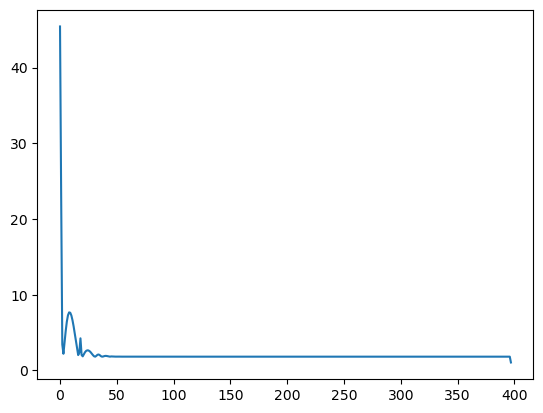

In [13]:
plt.figure()
plt.plot(total_batch_loss_list)

Push our data through the model to obtain an embedding

In [19]:
cnn_model.to('cpu').eval()
model_embedding_arr = torch.empty((0,1000)).to('cpu')
for batch_idx, (data, targets) in enumerate(train_loader):
    x = cnn_model.conv1(data.to('cpu'))
    x = cnn_model.relu(x)
    x = cnn_model.pool1(x)
    x = cnn_model.conv2(x)
    x = cnn_model.relu(x)
    x = cnn_model.pool2(x)
    x = torch.flatten(x, 1)
    x = cnn_model.fc1(x)
    model_embedding_arr = torch.concatenate((model_embedding_arr, x))

In [20]:
model_embedding_arr.shape

torch.Size([25445, 1000])

In [21]:
import umap
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(model_embedding_arr.cpu().detach().numpy())

In [22]:
# Parameters we set
num_spec = 10
window_size = 100
stride = 10


phrase_repeats = 5
num_songs = 10
radius_value = 0.01
num_syllables = 10

folderpath = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'
songpath = f'{folderpath}num_songs_{num_songs}_num_syllables_{num_syllables}_phrase_repeats_{phrase_repeats}_radius_{radius_value}/'

mean_colors_per_minispec = np.load(f'{songpath}mean_colors_per_minispec.npy')

In [23]:
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import pandas as pd

In [11]:
mean_colors_per_minispec_batch = mean_colors_per_minispec[batch_indices,:]

In [26]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename='umap_of_TweetyNet_Embed_NCE.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(embedding_umap, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding_umap[:,0], y = embedding_umap[:,1], colors=mean_colors_per_minispec))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{songpath}/Plots/Window_Plots/Window_{i}.png')

show(p)

# save(p)


In [13]:
pred_probs

tensor([[0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0.0045],
        [0

In [16]:
x = stacked_windows_tensor[batch_indices, :,:,:]
x = x.reshape(32, x.shape[1]*x.shape[2]*x.shape[3])


In [17]:
reducer = umap.UMAP()
umap_alone = reducer.fit_transform(x.cpu().detach().numpy())


In [18]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename='umap_alone.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(umap_alone, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = umap_alone[:,0], y = umap_alone[:,1], colors=mean_colors_per_minispec_batch))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{songpath}/Plots/Window_Plots/Window_{batch_indices[i]}.png')

show(p)

# save(p)

In [27]:
# %% Implementation of the NCC classifier 

actual_labels = np.max(stacked_labels_for_window, axis = 1)

unique_labels = np.unique(actual_labels)

avg_representation = np.zeros((unique_labels.shape[0], 2)) # 2nd dimension is UMAP embedding size

for lab in unique_labels:
    lab = int(lab)
    embedding_rows = np.where(actual_labels == lab)
    embedding_subset = np.squeeze(embedding_umap[embedding_rows, :])
    avg_representation[lab, :] = np.mean(embedding_subset, axis = 0)
    
pred_labels = []
for i in np.arange(embedding_umap.shape[0]):
    dist_metric = np.sum((embedding_umap[i,:] - avg_representation)**2, axis = 1)
    pred_labels.append(np.argmin(dist_metric))
    

acc_value = np.mean(actual_labels == pred_labels)

# This shows that the representations of syllables form centroid like geometry
# in representation space. 

from sklearn.metrics.cluster import v_measure_score


v_measure_score(actual_labels, np.array(pred_labels))

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an instance of SVC with a linear kernel
svc_classifier = SVC(kernel='linear')

# Train the classifier on the training data
svc_classifier.fit(embedding_umap, actual_labels)

# Make predictions on the test data
y_pred = svc_classifier.predict(embedding_umap)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(actual_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


In [29]:
v_measure_score(actual_labels, np.array(pred_labels))


0.8389776104293857

In [37]:
reducer_umap_alone = umap.UMAP()
embedding_umap_alone = reducer_umap_alone.fit_transform(stacked_windows)


In [38]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename='umap_alone.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(embedding_umap_alone, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding_umap_alone[:,0], y = embedding_umap_alone[:,1], colors=mean_colors_per_minispec))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{songpath}/Plots/Window_Plots/Window_{i}.png')

show(p)

# save(p)